In [1]:
import numpy as np
import os
from osgeo import gdal, osr
import matplotlib.pyplot as plt
import pandas as pd
import sys
#from scipy import ndimage as ndi
%matplotlib inline
from utils import biomass_coeffs, cal_biomass

In [4]:
veg_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/pp_veg_structure.csv')
den_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/GlobalWoodDensityDatabase.csv')

In [3]:
veg_df.columnsIndex(['Unnamed: 0', 'individualID', 'domainID', 'siteID', 'plotID',
       'subplotID', 'pointID', 'stemDistance', 'stemAzimuth', 'scientificName',
       'taxonRank', 'adjNorthing', 'adjEasting', 'adjCoordinateUncertainty',
       'adjDecimalLatitude', 'adjDecimalLongitude', 'adjElevation',
       'adjElevationUncertainty', 'growthForm', 'plantStatus', 'stemDiameter',
       'measurementHeight', 'height', 'baseCrownHeight', 'breakHeight',
       'breakDiameter', 'maxCrownDiameter', 'ninetyCrownDiameter',
       'canopyPosition', 'shape', 'basalStemDiameter',
       'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter',
       'ninetyBaseCrownDiameter', 'initialBandStemDiameter',
       'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap',
       'dendrometerCondition', 'bandStemDiameter'],
      dtype='object')

AttributeError: 'DataFrame' object has no attribute 'columnsIndex'

In [5]:
family_mapping = {'Quercus chrysolepis Liebm.': 'Fagaceae',
    'Ceanothus integerrimus Hook. & Arn.': 'Rhamnaceae',
    'Calocedrus decurrens (Torr.) Florin': 'Cupressaceae',
    'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells': 'Ericaceae',
    'Cercocarpus montanus Raf. var. glaber (S. Watson) F.L. Martin': 'Rosaceae',
    'Pinus ponderosa Lawson & C. Lawson': 'Pinaceae',
    'Chamaebatia foliolosa Benth.': 'Rosaceae',
    'Quercus kelloggii Newberry': 'Fagaceae',
    'Ceanothus cuneatus (Hook.) Nutt.': 'Rhamnaceae',
    'Unknown plant': '',
    'Ribes roezlii Regel': 'Grossulariaceae',
    'Pinus sp.': 'Pinaceae',
    'Pinus lambertiana Douglas': 'Pinaceae',
    'Sambucus nigra L.': 'Viburnaceae',
    'Carex densa (L.H. Bailey) L.H. Bailey': 'Cyperaceae',
    'Ceanothus sp.': 'Rhamnaceae'
}

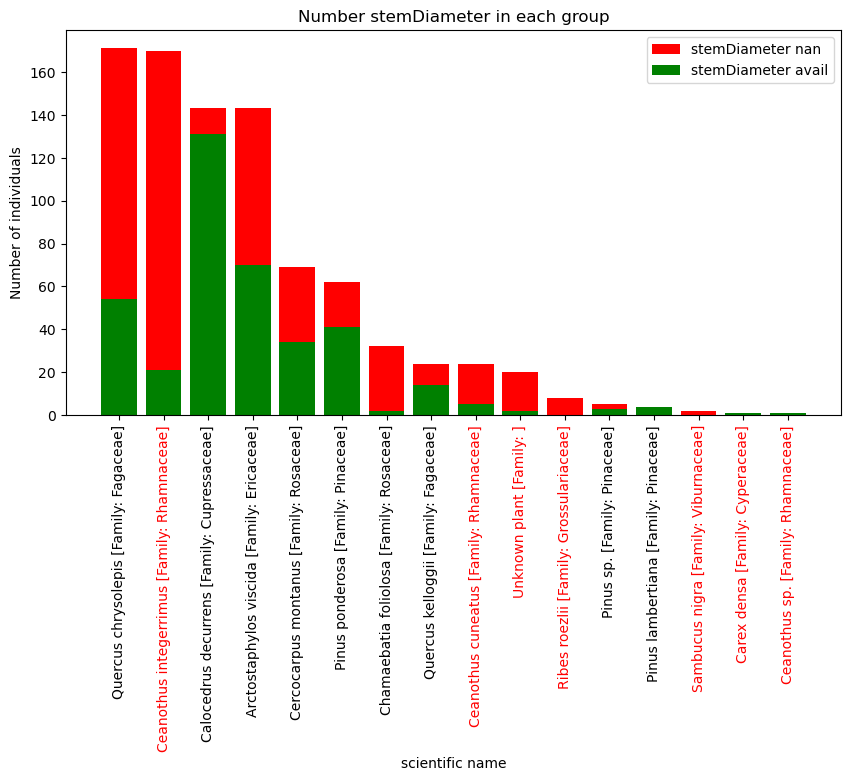

In [6]:
vegs = veg_df.scientificName.value_counts().to_dict()
def standardized_name(name):
    name = name.split()[:2]
    if name[-1] == 'sp.':
        name = name[0]
    else:
        name = ' '.join(name)
    return name

def avail_biomass_func(name):
    genus, n = name.split(' ')[:2]
    biomass_func = None
    if name == 'Unknown plant':
        pass
    elif genus in biomass_coeffs:
        biomass_func = biomass_coeffs[genus]
    else:
        if family_mapping[name] in biomass_coeffs:
            biomass_func = biomass_coeffs[family_mapping[name]]
    return biomass_func

result_biomass = []
for row in veg_df.itertuples():
    d = row.stemDiameter
    if not np.isnan(d):
        tree_name = row.scientificName
        genus, name = tree_name.split(' ')[:2]
        biomass_func = None
        if tree_name == 'Unknown plant':
            pass
        elif genus in biomass_coeffs:
            biomass_func = biomass_coeffs[genus]
        else:
            if family_mapping[tree_name] in biomass_coeffs:
                biomass_func = biomass_coeffs[family_mapping[tree_name]]

        if biomass_func:
            b1, b2 = biomass_func(d)
        
        biomass = cal_biomass(b1, b2, d)
        result_biomass.append(biomass)
    else:
        result_biomass.append(np.nan)

processed_vegs = {}
for k, v in vegs.items():
    processed_vegs[standardized_name(k)] = v

values = {}
groups = veg_df.groupby('scientificName')
for name, group in groups:
    nan_values = pd.isna(group.stemDiameter)
    values[name] = [np.sum(~nan_values), np.sum(nan_values)]

X = vegs.keys()
avail = np.array([values[i][0] for i in X])
nan = np.array([values[i][1] for i in X])

fig, axs = plt.subplots(figsize=(10, 5))
X_axis = np.arange(len(X))
plt.bar(X_axis, avail+nan, label='stemDiameter nan', color='red')
plt.bar(X_axis, avail, label='stemDiameter avail', color='green')
plt.xticks(X_axis, vegs.keys())
[label.set_color('red') for label in axs.xaxis.get_ticklabels() if not avail_biomass_func(label.get_text())]
plt.xticks(X_axis, [f"{' '.join(name.split()[:2])} [Family: {family_mapping[name]}]" for name in vegs.keys()])
plt.xticks(rotation = 90)
plt.xlabel("scientific name")
plt.ylabel("Number of individuals")
plt.title("Number stemDiameter in each group")
plt.legend()
plt.show()


In [12]:
total_avail_biomass_func = 0
total_avail = 0
for i in vegs.keys():
    total_avail += values[i][0]
    if avail_biomass_func(i):
        total_avail_biomass_func += values[i][0]
total_avail_biomass_func/total_avail

0.7441253263707572

In [37]:
exclude = ['Unknown plant']
result = []
for row in veg_df.itertuples():
    name = row.scientificName
    bs_area = row.basalStemDiameter
    if name in exclude:
        result.append(np.nan)
    else:
        if bs_area != np.nan:
            val = veg_df[veg_df.scientificName == name].basalStemDiameter.dropna().mean()
        else:
            val = veg_df[veg_df.scientificName == name].basalStemDiameter
        result.append(np.pi/4 * val**2)
result

[4.518351132658995,
 1.5289262342291958,
 1.5289262342291958,
 10.037879402071512,
 2.0106192982974664,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 10.037879402071512,
 1.5289262342291958,
 10.037879402071512,
 10.037879402071512,
 1.7671458676442586,
 1.7671458676442586,
 1.2867963509103788,
 10.037879402071512,
 10.037879402071512,
 1.2867963509103788,
 0.9503317777109126,
 0.9503317777109126,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 2.0106192982974664,
 21.231290384407522,
 21.231290384407522,
 21.231290384407522,
 21.2312903844

In [3]:
import os
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
polygons = gpd.read_file('/home/toanngo/Documents/GitHub/prisma/All_NEON_TOS_Plots_V9_0/All_NEON_TOS_Plots_V9/All_NEON_TOS_Plot_Polygons_V9.shp')

NameError: name 'gpd' is not defined

In [ ]:
polygons_soap = polygons[polygons.siteID == 'SOAP']
# polygons_soap = polygons[polygons.plotID.isin(['SOAP_001', 'SOAP_002', 'SOAP_003', 'SOAP_004'])]

: 

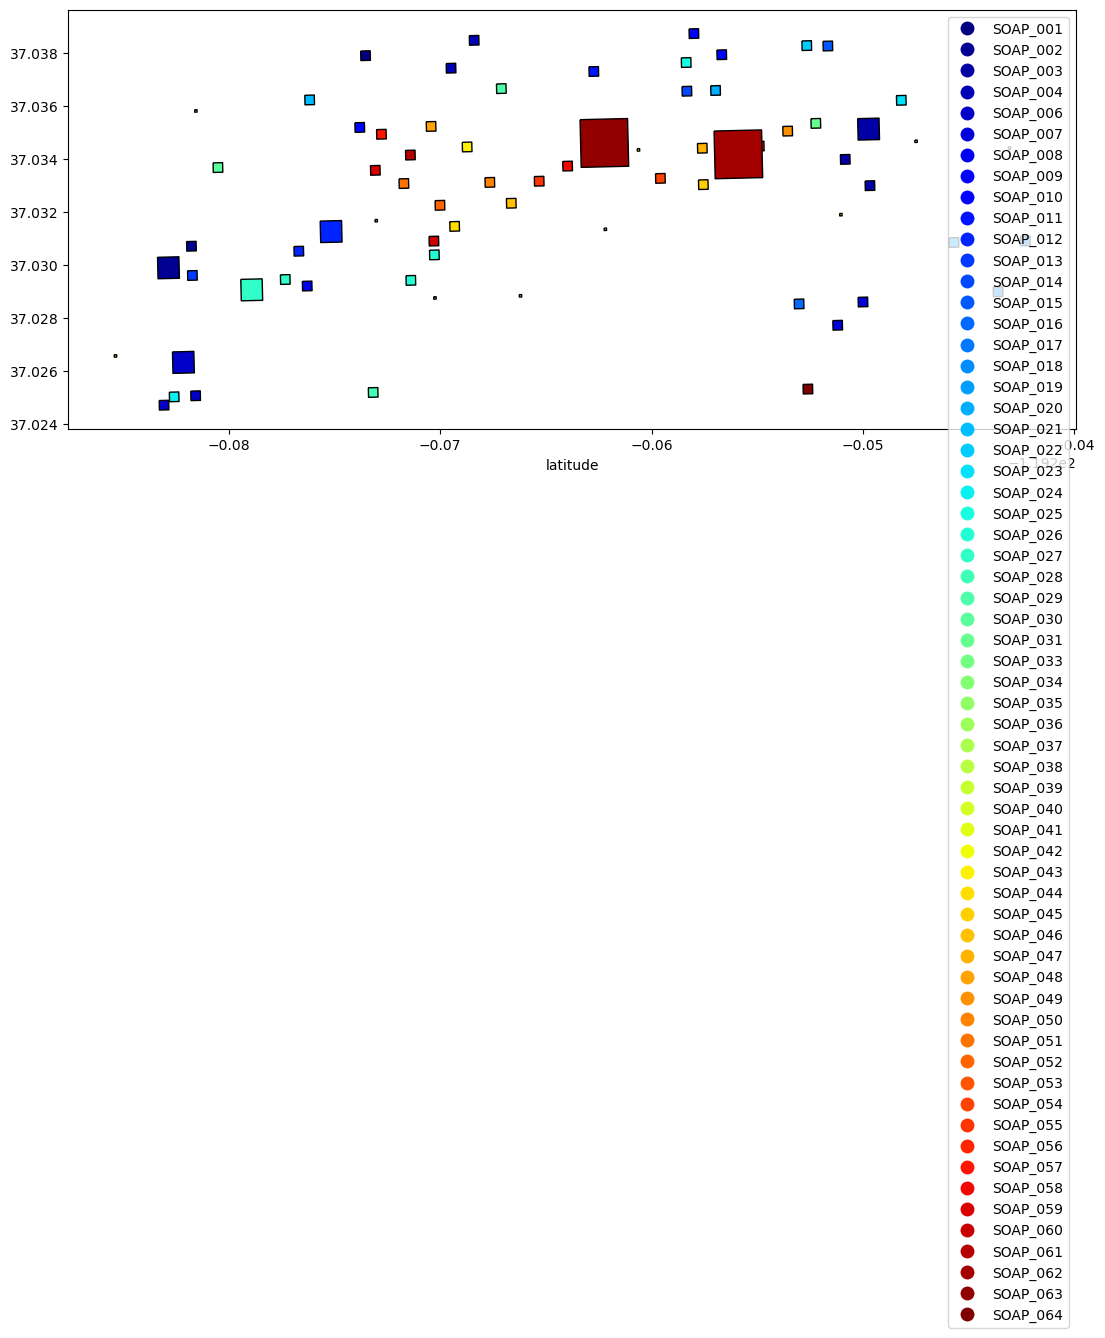

In [62]:
fig, ax = plt.subplots(1, figsize=(13, 10))
polygons_soap.plot(ax=ax, column='plotID', edgecolor='black', cmap='jet', legend=True)
plt.xlabel('longitude')
plt.xlabel('latitude')
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((1,0,2))
plt.show()


In [63]:
polygons_soap.crs

<Geographic 2D CRS: GEOGCS["GCS_WGS_84_with_axis_order_normalized_for_ ...>
Name: GCS_WGS_84_with_axis_order_normalized_for_visualization
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [64]:
polygons_soap_utm = polygons_soap.to_crs('epsg:32611')

In [65]:
polygons_soap_utm.crs

<Derived Projected CRS: EPSG:32611>
Name: WGS 84 / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 120°W and 114°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - Alberta; British Columbia (BC); Northwest Territories (NWT); Nunavut. Mexico. United States (USA).
- bounds: (-120.0, 0.0, -114.0, 84.0)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [66]:
test_polygon = polygons_soap_utm.geometry.iloc[0]

In [67]:
from shapely.geometry import shape
shape(test_polygon).area

1600.0000000349246

In [68]:
#polygons_soap_utm.to_file('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/shapefile/plot_polygons_SOAP.shp')
# polygons_soap_utm = gpd.read_file('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/shapefile/plot_polygons_SOAP.shp')

In [69]:
polygons_soap_utm

,plotID,pointID,country,state,county,domain,domainID,siteName,siteID,plotType,...,nlcdClass,soilOrder,coordSrc,date,gpsLogs,plotPdop,plotHdop,appMods,plotEdge,geometry
1811,SOAP_001,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,Geo 7X (H-Star),20160928,356.0,6.6,2.9,bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((297776.108 4101513.765, 297816.108 4..."
1812,SOAP_002,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,None,GeoXH 6000,20180829,400.0,5.8,3.0,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((297024.459 4100732.894, 297064.459 4..."
1813,SOAP_003,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20161004,364.0,2.4,1.0,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((299784.413 4101031.247, 299824.413 4..."
1814,SOAP_004,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,Geo 7X (H-Star),20160928,438.0,4.4,2.6,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((298134.702 4101452.800, 298174.702 4..."
1815,SOAP_006,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20160913,366.0,3.4,1.1,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((297026.942 4100105.944, 297066.942 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,SOAP_002,E5,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,None,Geo 7X (H-Star),20150625,711.0,7.7,5.2,mam,90.0,"POLYGON ((296900.596 4100669.878, 296990.596 4..."
1880,SOAP_003,E5,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,Geo 7X (H-Star),20150630,701.0,3.0,1.8,mam,90.0,"POLYGON ((299860.618 4101180.756, 299950.618 4..."
1881,SOAP_006,E5,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,Geo 7X (H-Star),20150624,692.0,6.3,4.0,mam,90.0,"POLYGON ((296953.962 4100271.952, 297043.962 4..."
1882,SOAP_012,E5,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GIS,None,NaN,NaN,NaN,mam,90.0,"POLYGON ((297588.718 4100805.235, 297678.718 4..."


In [71]:
polygons_soap_utm['area'] = polygons_soap_utm.area
polygons_soap_utm.explore("area", legend=True)

In [11]:
def get_polygon_str(x_cord, y_cord):
    polygon_str = 'POLYGON(('
    for x, y in zip(list(x_cord), list(y_cord)):
        polygon_str += f'{x} {y}, '
    polygon_str = polygon_str[:-2]
    polygon_str += '))'
    return polygon_str

In [44]:
polygons_soap_utm.geometry.iloc[0].exterior.coords.xy[0].tolist()

[297776.1080000003,
 297816.10799999896,
 297816.10800000106,
 297776.1080000003,
 297776.1080000003]

In [45]:
get_polygon_str(polygons_soap_utm.geometry.iloc[0].exterior.coords.xy[0].tolist(), polygons_soap_utm.geometry.iloc[0].exterior.coords.xy[1].tolist())

'POLYGON((297776.1080000003 4101513.765, 297816.10799999896 4101513.7650000006, 297816.10800000106 4101473.7649999997, 297776.1080000003 4101473.7649999987, 297776.1080000003 4101513.765))'

In [93]:
polygons_soap_utm.shape[0]

73

In [14]:
import pdal
import os
# os.environ['PROJ_LIB']

os.environ['PROJ_LIB'] = '/home/toanngo/anaconda3/envs/prisma/share/proj' #'opt/conda/shared/proj'

In [13]:
from pathlib import Path
input_laz_path = Path('/media/toanngo/My Passport/lidar/SOAP/2019-06/laz')
output_laz_path = Path('/media/toanngo/My Passport/lidar/SOAP/2019-06/clipped_laz')

In [14]:
laz_file_paths = [f for f in input_laz_path.glob('*colorized.laz')]

In [102]:
len(laz_file_paths)

199

In [99]:
str(output_laz_path/f"{polygons_soap_utm.plotID.iloc[0]}_{laz_file_path.stem}.laz")

'/media/toanngo/My Passport/lidar/SOAP/2019-06/clipped_laz/SOAP_001_NEON_D17_SOAP_DP1_302000_4102000_classified_point_cloud_colorized.laz'

In [13]:
polygons_soap_utm.plotID.iloc[0]

'SOAP_001'

In [14]:
import json
import os
from tqdm import tqdm

for laz_file_path in tqdm(laz_file_paths):
    for i in tqdm(range(polygons_soap_utm.shape[0]), leave=False):
        pdal_json = {
            "pipeline": [
                {
                    "type": "readers.las",
                    "filename": str(laz_file_path)
                },
                {
                    "type": "filters.crop",
                    "polygon": get_polygon_str(polygons_soap_utm.geometry.iloc[i].exterior.coords.xy[0].tolist(), polygons_soap_utm.geometry.iloc[i].exterior.coords.xy[1].tolist()),
                },
                {
                    "type": "writers.las",
                    "filename": str(output_laz_path/f"{polygons_soap_utm.plotID.iloc[i]}_{i}_{laz_file_path.stem}.laz"),
                    "extra_dims": "all"
                }
            ]
        }
        pdal_json_str = json.dumps(pdal_json)
        pipeline = pdal.Pipeline(pdal_json_str)
        count = pipeline.execute()
        if count == 0:
            os.remove(str(output_laz_path/f"{polygons_soap_utm.plotID.iloc[i]}_{i}_{laz_file_path.stem}.laz"))



  0%|          | 0/199 [23:37<?, ?it/s]


KeyboardInterrupt: 

In [104]:
import tqdm

In [84]:
import json
#laz_path = f'/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/lidar/SOAP_002/NEON_D17_SOAP_DP1_292000_4101000_classified_point_cloud_colorized.laz'
laz_path = '/media/toanngo/My Passport/lidar/SOAP/2019-06/laz/NEON_D17_SOAP_DP1_297000_4001000_classified_point_cloud_colorized.laz'
pdal_json = {
    "pipeline": [
        {
            "type": "readers.las",
            "filename": laz_path
        },
        {
            "type": "filters.crop",
            "polygon": [get_polygon_str(polygons_soap_utm.geometry.iloc[0].exterior.coords.xy[0].tolist(), polygons_soap_utm.geometry.iloc[0].exterior.coords.xy[1].tolist()), get_polygon_str(polygons_soap_utm.geometry.iloc[1].exterior.coords.xy[0].tolist(), polygons_soap_utm.geometry.iloc[1].exterior.coords.xy[1].tolist())],
        },
        {
        "type": "writers.las",
        "filename": '/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/lidar/SOAP_002/output.laz',
        "extra_dims": "all"
        }
    ]
}
pdal_json_str = json.dumps(pdal_json)
pipeline = pdal.Pipeline(pdal_json_str)
count = pipeline.execute()
print(count, end=" ")


7443 

In [98]:
type(count)

int

In [54]:
pipeline = [
        {
            "type": "readers.las",
            "filename": laz_path
        }
    ]

In [55]:
pipeline = pdal.Pipeline(json.dumps(pipeline))
pipeline.execute()

41383

In [58]:
metadata = pipeline.metadata

In [61]:
from osgeo import osr

horz_srs = osr.SpatialReference(metadata["metadata"]["readers.las"]["srs"]["horizontal"])
horz_epsg = horz_srs.GetAttrValue("AUTHORITY", 1)

vert_srs = osr.SpatialReference(metadata["metadata"]["readers.las"]["srs"]["vertical"])
vert_epsg = vert_srs.GetAttrValue("AUTHORITY", 1)

In [62]:
horz_srs, horz_epsg, vert_srs, vert_epsg

(<osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x7efec6c10870> >,
 '32611',
 <osgeo.osr.SpatialReference; proxy of <Swig Object of type 'OSRSpatialReferenceShadow *' at 0x7efec6c10780> >,
 '9001')

In [63]:
metadata

{'metadata': {'filters.merge': {},
  'readers.las': {'comp_spatialreference': 'COMPD_CS["WGS 84 / UTM zone 11N + unknown",PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]],VERT_CS["unknown",VERT_DATUM["unknown",2005],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Up",UP]]]',
   'compressed': True,
   'copc': False,
   'count': 41383,
   'creation_doy': 219,
   'creation_year': 2019,
   'dataformat_id': 3,
   'dataoffset': 517,
   'filesource_id':

In [73]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr  8 08:18:00 2019
@author: bhass

Functions to display available urls and download NEON AOP data using the NEON Data API.
"""

import requests, urllib, os

def list_available_urls(product,site):
    """
    list_available urls lists the api url for a given product and site
    --------
     Inputs:
         product: the data product code (eg. 'DP3.30015.001' - CHM)
         site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
    --------
    Usage:
    --------
    jorn_chm_urls = list_available_urls('DP3.30015.001','JORN')
    """
    r = requests.get("http://data.neonscience.org/api/v0/products/" + product)
    for i in range(len(r.json()['data']['siteCodes'])):
        if site in r.json()['data']['siteCodes'][i]['siteCode']:
            data_urls=r.json()['data']['siteCodes'][i]['availableDataUrls']
    if len(data_urls)==0:
        print('WARNING: no urls found for product ' + product + ' at site ' + site)
    else:
        return data_urls

def list_available_urls_by_year(product,site,year):
    """
    list_available urls_by_year lists the api url for a given product, site, and year
    --------
     Inputs:
         product: the data product code (eg. 'DP3.30015.001' - CHM)
         site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
         year: the year data was collected (eg. '2017','2018','2019')
    --------
    Usage:
    --------
    jorn_chm_2018_url = list_available_urls_by_year('DP3.30015.001','JORN','2018')
    """
    r = requests.get("http://data.neonscience.org/api/v0/products/" + product)
    for i in range(len(r.json()['data']['siteCodes'])):
        if site in r.json()['data']['siteCodes'][i]['siteCode']:
            all_data_urls=r.json()['data']['siteCodes'][i]['availableDataUrls']
    data_urls = [url for url in all_data_urls if year in url]
    if len(data_urls)==0:
        print('WARNING: no urls found for product ' + product + ' at site ' + site + ' in year ' + year)
    else:
        return data_urls
    
def download_urls(url_list,download_folder_root,zip=False):
    # downloads data from urls to folder, maintaining month-year folder structure
    for url in url_list:
        month = url.split('/')[-1]
        download_folder = download_folder_root + month + '/'
        if not os.path.exists(download_folder):
            os.makedirs(download_folder)
        r=requests.get(url)
        files=r.json()['data']['files']
        for i in range(len(files)):
            if zip==False:
                if '.zip' not in files[i]['name']:
                    print('downloading ' + files[i]['name'] + ' to ' + download_folder)
                    urllib.request.urlretrieve(files[i]['url'],download_folder + files[i]['name'])
            elif zip==True:
                if '.zip' in files[i]['name']:
                    print('downloading ' + files[i]['name'] + ' to ' + download_folder)
                    urllib.request.urlretrieve(files[i]['url'],download_folder + files[i]['name'])

def download_file(url,filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    return

def get_file_size(urls,match_string):
    size=0
    for url in urls:
        r = requests.get(url)
        files = r.json()['data']['files']
        for i in range(len(files)):
            if match_string is not None:
                if match_string in files[i]['name']:
    #             print('downloading ' + files[i]['name'] + ' to ' + download_folder)
                    size += int(files[i]['size'])
            else:
                size += int(files[i]['size'])
    if size < 10**3:
        print('Download size:',size,'bytes')
    elif size > 10**3 and size < 10**6:
        print('Download size:',round(size/(10**6),2),'kB')
    elif size > 10**6 and size < 10**9:
        print('Download size:',round(size/(10**6),2),'MB')
    elif size > 10**9 and size < 10**12:
        print('Download size:',round(size/(10**9),2),'GB')
    else:
        print('Download size:',round(size/(10**12),2),'TB')
    return size

def download_aop_files(product,site,year=None,download_folder='./data',match_string=None,check_size=True):
    """
    download_aop_files downloads NEON AOP files from the AOP for a given data product, site, and 
    optional year, download folder, and 
    --------
     Inputs:
         required:
             product: the data product code (eg. 'DP3.30015.001' - CHM)
             site: the 4-digit NEON site code (eg. 'SRER', 'JORN')
         
         optional:
             year: year (eg. '2020'); default (None) is all years
             download_folder: folder to store downloaded files; default (./data) in current directory
             match_string: subset of data to match, need to use exact pattern for file name
             check_size: prompt to continue download (y/n) after displaying size; default = True
    --------
    Usage:
    --------
    download_aop_files('DP3.30015.001','JORN','2019','./data/JORN_2019/CHM','314000_3610000_CHM.tif')
    """
    
    #get a list of the urls for a given data product, site, and year (if included)
    if year is not None:
        urls = list_available_urls_by_year(product,site,year)
    else:
        urls = list_available_urls(product,site)
    
    #make the download folder if it doesn't already exist
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    
    #get the size of all the files you are planning to download
    size = get_file_size(urls,match_string)
    
    #prompt to continue with download after displaying the file size
    if check_size:
        if input("Do you want to continue with the download? (y/n) ") != "y":
            print('Exiting download_aop_files')
            return
    
    #download files in the urls
    for url in urls:
        r = requests.get(url)
        files = r.json()['data']['files']
        for i in range(len(files)):
            if match_string is not None:
                if match_string in files[i]['name']:
                    print('downloading ' + files[i]['name'] + ' to ' + download_folder)
                    try:
                        download_file(files[i]['url'],os.path.join(download_folder, files[i]['name']))
                    except requests.exceptions.RequestException as e:
                        print(e)
            else:
                try:
                    download_file(files[i]['url'],os.path.join(download_folder, files[i]['name']))
                except requests.exceptions.RequestException as e:
                    print(e)

In [74]:
# tif: raserized file
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from mpl_toolkits.mplot3d import axes3d

In [75]:
PATH = Path('/media/toanngo/My Passport/lidar')

In [76]:
PRODUCTCODE = 'DP1.30003.001'
SITE = 'SOAP'
DATE = '2019-06'
ROOT_PATH = PATH/SITE/DATE
FILE_TYPES = ['prj', 'laz', 'kml', 'shx', 'shp', 'dbf']
TYPE_PATHS = [ROOT_PATH/file_type for file_type in FILE_TYPES]
# SHP_PATH = ROOT_PATH/'shp'
# KML_PATH = ROOT_PATH/'kml'
# LAZ_PATH = ROOT_PATH/'laz'
# LAZ_PATH = ROOT_PATH/'laz'
# TILE = '302000_4104000'
# L3_PATH = ROOT_PATH/'L3'
# L3_PRODUCTCODE = {'CHM': 'DP3.30015.001',
#                   'DTM': 'DP3.30024.001',
#                   'DSM': 'DP3.30024.001'}

In [77]:
for file_type in FILE_TYPES:
  type_path = ROOT_PATH/file_type
  download_aop_files(PRODUCTCODE, SITE, DATE, str(type_path), match_string=file_type, check_size=False)

Download size: 0.08 kB
downloading NEON_D17_SOAP_DP1_293000_4106000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_304000_4108000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_304000_4107000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_306000_4102000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_299000_4105000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_298000_4100000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_299000_4100000_classified_point_cloud.prj to /media/toanngo/My Passport/lidar/SOAP/2019-06/prj
downloading NEON_D17_SOAP_DP1_298000_4103000_classified_point_cloud.prj to /media/toanngo/My Passport/

In [2]:
import geopandas as gpd
polygons_soap_all_utm = gpd.read_file('/media/toanngo/My Passport/lidar/SOAP/2019-06/merged_shp/2019_SOAP_4_merged_tiles.shp')

In [3]:
polygons_soap_all_utm['area'] = polygons_soap_all_utm.area
polygons_soap_all_utm.explore("area", legend=False)

In [15]:
target_tiles = ['NEON_D17_SOAP_DP1_296000_4100000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_297000_4100000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_298000_4100000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_299000_4100000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_300000_4100000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_297000_4101000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_298000_4101000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_299000_4101000_classified_point_cloud',
                'NEON_D17_SOAP_DP1_300000_4101000_classified_point_cloud',
                ]
polygons_soap_all_utm[polygons_soap_all_utm.TileID.isin(target_tiles)]

,TileID,geometry,area
49,NEON_D17_SOAP_DP1_296000_4100000_classified_po...,"POLYGON ((296949.080 4100999.990, 296961.410 4...",999970.226928
64,NEON_D17_SOAP_DP1_297000_4100000_classified_po...,"POLYGON ((297519.270 4100999.990, 297519.990 4...",999966.814877
65,NEON_D17_SOAP_DP1_297000_4101000_classified_po...,"POLYGON ((297999.990 4101854.540, 297999.990 4...",999968.835889
79,NEON_D17_SOAP_DP1_298000_4100000_classified_po...,"POLYGON ((298999.990 4100913.890, 298999.990 4...",999967.043015
80,NEON_D17_SOAP_DP1_298000_4101000_classified_po...,"POLYGON ((298865.780 4101999.990, 298872.850 4...",999973.497404
94,NEON_D17_SOAP_DP1_299000_4100000_classified_po...,"POLYGON ((299884.780 4100999.990, 299887.000 4...",999964.132806
95,NEON_D17_SOAP_DP1_299000_4101000_classified_po...,"POLYGON ((299999.990 4101898.000, 299999.990 4...",999967.019473
109,NEON_D17_SOAP_DP1_300000_4100000_classified_po...,"POLYGON ((300844.090 4100999.980, 300887.260 4...",999954.685060
110,NEON_D17_SOAP_DP1_300000_4101000_classified_po...,"POLYGON ((300999.970 4101678.600, 300999.990 4...",999965.226424


In [18]:
from pathlib import Path
shp_paths = Path('/media/toanngo/My Passport/lidar/SOAP/2019-06/merged_shp')
shp_file_paths = [i for i in shp_paths.glob('*_classified_point_cloud.shp')]

In [19]:
shp_file_path = shp_file_paths[0]

In [20]:
shp_file = gpd.read_file(shp_file_path)

In [21]:
shp_file

,geometry
0,"POLYGON Z ((292988.040 4098855.320 643.800, 29..."


# Cut all polygons

In [15]:
import json
import os
from tqdm import tqdm

polygons = [get_polygon_str(polygons_soap_utm.geometry.iloc[i].exterior.coords.xy[0].tolist(), polygons_soap_utm.geometry.iloc[i].exterior.coords.xy[1].tolist()) for i in range(polygons_soap_utm.shape[0])]
for laz_file_path in tqdm(laz_file_paths):
    pdal_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": str(laz_file_path)
            },
            {
                "type": "filters.crop",
                "polygon": polygons,
            },
            {
                "type": "writers.las",
                "filename": str(output_laz_path/f"{laz_file_path.stem}.laz"),
                "extra_dims": "all"
            }
        ]
    }
    pdal_json_str = json.dumps(pdal_json)
    pipeline = pdal.Pipeline(pdal_json_str)
    count = pipeline.execute()
    if count == 0:
        os.remove(str(output_laz_path/f"{laz_file_path.stem}.laz"))



100%|██████████| 199/199 [4:47:21<00:00, 86.64s/it]   


# Merge files

In [21]:
import json
import os
from tqdm import tqdm
from pathlib import Path
laz_list = [str(i) for i in Path('/media/toanngo/My Passport/lidar/SOAP/2019-06/clipped_laz').glob('*.laz')]

pdal_json = {
    "pipeline": laz_list + [
        {
            "type": "filters.merge"
        },
        {
            "type": "writers.las",
            "filename": '/media/toanngo/My Passport/lidar/SOAP/2019-06/merge.laz',
            "extra_dims": "all"
        }
    ]
}
pdal_json_str = json.dumps(pdal_json)
pipeline = pdal.Pipeline(pdal_json_str)
count = pipeline.execute()
print(count)



1050656


In [28]:
import json
import os
from tqdm import tqdm

polygons_soap_utm_inv = polygons_soap_utm[polygons_soap_utm.plotID.isin(list(veg_df.plotID.unique()))]
for row in tqdm(polygons_soap_utm_inv.itertuples()):
    pdal_json = {
        "pipeline": [
            {
                "type": "readers.las",
                "filename": '/media/toanngo/My Passport/lidar/SOAP/2019-06/merge.laz'
            },
            {
                "type": "filters.crop",
                "polygon": get_polygon_str(row.geometry.exterior.coords.xy[0].tolist(),
                                           row.geometry.exterior.coords.xy[1].tolist()),
            },
            {
                "type": "writers.las",
                "filename": f"/media/toanngo/My Passport/lidar/SOAP/2019-06/clipped_inv_laz/{row.plotID}_{row.pointID}.laz",
                "extra_dims": "all"
            }
        ]
    }
    pdal_json_str = json.dumps(pdal_json)
    pipeline = pdal.Pipeline(pdal_json_str)
    count = pipeline.execute()
    print(count)



2it [00:05,  2.79s/it]

11283
7703


3it [00:09,  3.02s/it]

5782


5it [00:16,  3.43s/it]

10413
10797


6it [00:20,  3.56s/it]

10492


8it [00:27,  3.68s/it]

11505
6587


9it [00:31,  3.73s/it]

5147


11it [00:39,  3.81s/it]

10330
9158


12it [00:43,  3.80s/it]

7660


13it [00:47,  3.81s/it]

5564


15it [00:52,  3.26s/it]

4846
6032


16it [00:54,  2.90s/it]

9901


17it [00:57,  2.67s/it]

9715


19it [01:01,  2.37s/it]

5847
11506


21it [01:05,  2.19s/it]

8401
5217


23it [01:09,  2.13s/it]

4892
33236


24it [01:11,  2.19s/it]

36172


26it [01:15,  2.15s/it]

52835
44539


26it [01:15,  2.92s/it]


In [15]:
polygons_soap_utm[polygons_soap_utm.plotID.isin(list(veg_df.plotID.unique()))]

,plotID,pointID,country,state,county,domain,domainID,siteName,siteID,plotType,...,nlcdClass,soilOrder,coordSrc,date,gpsLogs,plotPdop,plotHdop,appMods,plotEdge,geometry
1812,SOAP_002,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,None,GeoXH 6000,20180829,400.0,5.8,3.0,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((297024.459 4100732.894, 297064.459 4..."
1813,SOAP_003,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20161004,364.0,2.4,1.0,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((299784.413 4101031.247, 299824.413 4..."
1814,SOAP_004,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,Geo 7X (H-Star),20160928,438.0,4.4,2.6,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((298134.702 4101452.800, 298174.702 4..."
1815,SOAP_006,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20160913,366.0,3.4,1.1,bet|bgc|brd|cdw|cfc|dhp|div|hbp|sme|vst,40.0,"POLYGON ((297026.942 4100105.944, 297066.942 4..."
1816,SOAP_007,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20161004,439.0,2.1,1.0,bet|brd|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((299844.890 4100431.874, 299884.890 4..."
1817,SOAP_008,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,None,GeoXH 6000,20161004,408.0,3.1,1.7,bet|brd|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((297507.616 4100554.479, 297547.616 4..."
1818,SOAP_009,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,shrubScrub,Alfisols,GeoXH 6000,20160929,401.0,2.9,0.9,brd|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((299275.188 4101482.123, 299315.188 4..."
1819,SOAP_010,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,shrubScrub,Alfisols,Geo 7X (H-Star),20160912,363.0,3.1,0.9,brd|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((297744.641 4101213.791, 297784.641 4..."
1821,SOAP_012,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20180829,320.0,4.4,1.6,bet|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((297475.758 4100701.198, 297515.758 4..."
1822,SOAP_013,41,unitedStates,CA,Fresno,Pacific Southwest,D17,Soaproot Saddle NEON,SOAP,distributed,...,evergreenForest,Alfisols,GeoXH 6000,20180829,310.0,7.0,3.9,bet|cdw|cfc|dhp|div|hbp|vst,40.0,"POLYGON ((297025.530 4100610.368, 297065.530 4..."


# Plot summary

In [1]:
veg_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/pp_veg_structure.csv')
veg_df = veg_df.drop(['Unnamed: 0'], axis=1)

NameError: name 'pd' is not defined

In [ ]:
polygons = polygons_soap_utm[polygons_soap_utm.plotID.isin(list(veg_df.plotID.unique()))]
polygons = polygons[polygons.pointID == '41']

In [18]:
polygons.geometry

1812    POLYGON ((297024.459 4100732.894, 297064.459 4...
1813    POLYGON ((299784.413 4101031.247, 299824.413 4...
1814    POLYGON ((298134.702 4101452.800, 298174.702 4...
1815    POLYGON ((297026.942 4100105.944, 297066.942 4...
1816    POLYGON ((299844.890 4100431.874, 299884.890 4...
1817    POLYGON ((297507.616 4100554.479, 297547.616 4...
1818    POLYGON ((299275.188 4101482.123, 299315.188 4...
1819    POLYGON ((297744.641 4101213.791, 297784.641 4...
1821    POLYGON ((297475.758 4100701.198, 297515.758 4...
1822    POLYGON ((297025.530 4100610.368, 297065.530 4...
1823    POLYGON ((299722.481 4101508.051, 299762.481 4...
1824    POLYGON ((299575.893 4100430.180, 299615.893 4...
1825    POLYGON ((300534.094 4100671.420, 300574.094 4...
1826    POLYGON ((300414.504 4100461.567, 300454.504 4...
1827    POLYGON ((300233.710 4100672.237, 300273.710 4...
1828    POLYGON ((299245.588 4101332.940, 299285.588 4...
1829    POLYGON ((297536.554 4101333.920, 297576.554 4...
1863    POLYGO

In [19]:
veg_df_stem = veg_df[~pd.isna(veg_df.stemDiameter)]
veg_df_stem_002 = veg_df_stem[veg_df_stem.plotID == 'SOAP_002']
veg_df_stem_002.columns

Index(['individualID', 'domainID', 'siteID', 'plotID', 'subplotID', 'pointID',
       'stemDistance', 'stemAzimuth', 'scientificName', 'taxonRank',
       'adjNorthing', 'adjEasting', 'adjCoordinateUncertainty',
       'adjDecimalLatitude', 'adjDecimalLongitude', 'adjElevation',
       'adjElevationUncertainty', 'growthForm', 'plantStatus', 'stemDiameter',
       'measurementHeight', 'height', 'baseCrownHeight', 'breakHeight',
       'breakDiameter', 'maxCrownDiameter', 'ninetyCrownDiameter',
       'canopyPosition', 'shape', 'basalStemDiameter',
       'basalStemDiameterMsrmntHeight', 'maxBaseCrownDiameter',
       'ninetyBaseCrownDiameter', 'initialBandStemDiameter',
       'initialDendrometerGap', 'dendrometerHeight', 'dendrometerGap',
       'dendrometerCondition', 'bandStemDiameter'],
      dtype='object')

In [20]:
veg_df_stem_002[['adjEasting', 'adjNorthing']].dropna().apply(list, axis=1)

13     [297034.474322341, 4100704.1274753]
14    [297039.668274839, 4100706.00467016]
16     [297041.68949078, 4100707.10592992]
17    [297037.005918536, 4100708.64165361]
18     [297036.46868033, 4100710.22758128]
21     [297042.01223603, 4100724.30689327]
23    [297052.217782754, 4100707.93486506]
27    [297038.405534308, 4100714.32840667]
28    [297052.332440688, 4100719.84940451]
34     [297050.177716119, 4100705.2400194]
dtype: object

In [21]:
from shapely.geometry import Point, Polygon
Point([297052.217782754, 4100707.93486506]).within(polygons.geometry[polygons.plotID == 'SOAP_002'])


1812    True
Name: geometry, dtype: bool

In [22]:
polygons['area'] = polygons.area
polygons_area = polygons[['plotID', 'geometry', 'area']]
veg_area_df = pd.merge(veg_df, polygons_area, on=['plotID'])
veg_area_df = veg_area_df[~pd.isna(veg_area_df.stemDiameter)]
veg_area_df = veg_area_df[veg_area_df.stemDiameter >=10]
veg_area_df['individualStemNumberDensity'] = 1/veg_area_df.area
veg_area_df['individualBasalArea'] = np.pi/4*veg_area_df.stemDiameter**2


In [23]:
veg_area_df.scientificName.unique()

array(['Quercus chrysolepis Liebm.', 'Pinus ponderosa Lawson & C. Lawson',
       'Calocedrus decurrens (Torr.) Florin',
       'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells',
       'Pinus lambertiana Douglas', 'Quercus kelloggii Newberry',
       'Pinus sp.', 'Carex densa (L.H. Bailey) L.H. Bailey'], dtype=object)

In [24]:
family_mapping = {'Quercus chrysolepis Liebm.': 'Fagaceae',
    'Ceanothus integerrimus Hook. & Arn.': 'Rhamnaceae',
    'Calocedrus decurrens (Torr.) Florin': 'Cupressaceae',
    'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells': 'Ericaceae',
    'Cercocarpus montanus Raf. var. glaber (S. Watson) F.L. Martin': 'Rosaceae',
    'Pinus ponderosa Lawson & C. Lawson': 'Pinaceae',
    'Chamaebatia foliolosa Benth.': 'Rosaceae',
    'Quercus kelloggii Newberry': 'Fagaceae',
    'Ceanothus cuneatus (Hook.) Nutt.': 'Rhamnaceae',
    'Unknown plant': '',
    'Ribes roezlii Regel': 'Grossulariaceae',
    'Pinus sp.': 'Pinaceae',
    'Pinus lambertiana Douglas': 'Pinaceae',
    'Sambucus nigra L.': 'Viburnaceae',
    'Carex densa (L.H. Bailey) L.H. Bailey': 'Cyperaceae',
    'Ceanothus sp.': 'Rhamnaceae'
}
family_df = pd.DataFrame.from_dict({'scientificName': family_mapping.keys(), 'family': family_mapping.values()})

In [25]:
family_df

,scientificName,family
0,Quercus chrysolepis Liebm.,Fagaceae
1,Ceanothus integerrimus Hook. & Arn.,Rhamnaceae
2,Calocedrus decurrens (Torr.) Florin,Cupressaceae
3,Arctostaphylos viscida Parry ssp. mariposa (Du...,Ericaceae
4,Cercocarpus montanus Raf. var. glaber (S. Wats...,Rosaceae
5,Pinus ponderosa Lawson & C. Lawson,Pinaceae
6,Chamaebatia foliolosa Benth.,Rosaceae
7,Quercus kelloggii Newberry,Fagaceae
8,Ceanothus cuneatus (Hook.) Nutt.,Rhamnaceae
9,Unknown plant,


In [26]:
veg_family_area_df = pd.merge(veg_area_df, family_df, on=['scientificName'])

In [44]:
result = []
for row in veg_family_area_df.itertuples():
    biomass = np.nan
    func = biomass_coeffs.get(row.family, None)
    if func:
        coeffs = func(row.stemDiameter)
        biomass = cal_biomass(*coeffs, row.stemDiameter)
    result.append(biomass)
veg_family_area_df['biomass'] = result

In [46]:
veg_family_area_df.to_csv('pp_veg_structure_IND_IBA_IAGB.csv', index=False)

In [50]:
plots = []
ND = []
BA = []
ABCD = []

for plot_id, group in veg_family_area_df.groupby('plotID'):
    plots.append(plot_id)
    ND.append(group.individualStemNumberDensity.sum())
    BA.append(group.individualBasalArea.sum())
    ABCD.append(group.biomass.sum())

In [51]:
plot_level_df = pd.DataFrame.from_dict({'plotID': plots,
                        'stemNumberDensity': ND,
                        'basalArea': BA,
                        'biomass': ABCD})


In [52]:
veg_family_area_df.to_csv('plot-level_pp_veg_structure_IND_IBA_IAGB_DBH-geq-10.csv', index=False)

In [9]:
[i for i in polygons.plotSize.unique()]

[1600.0, 40000.0, 0.0, 8100.0, 250000.0, 400.0, 160.0, 6400.0, 16000.0]

# DBH < 10

In [6]:
import pandas as pd
veg_df = pd.read_csv('/home/toanngo/Documents/GitHub/prisma/preprocessing/data/SOAP/2019/pp_veg_structure.csv')
veg_df = veg_df.drop(['Unnamed: 0'], axis=1)

In [8]:
~pd.isna(veg_df.stemDiameter) & ~pd.isna(veg_df.basalStemDiameter)

135

In [10]:
veg_df[~pd.isna(veg_df.basalStemDiameter) | ~pd.isna(veg_df.stemDiameter)].scientificName.unique()

array(['Cercocarpus montanus Raf. var. glaber (S. Watson) F.L. Martin',
       'Pinus ponderosa Lawson & C. Lawson',
       'Calocedrus decurrens (Torr.) Florin',
       'Quercus chrysolepis Liebm.', 'Quercus kelloggii Newberry',
       'Sambucus nigra L.', 'Ribes roezlii Regel',
       'Arctostaphylos viscida Parry ssp. mariposa (Dudley) P.V. Wells',
       'Pinus lambertiana Douglas', 'Ceanothus integerrimus Hook. & Arn.',
       'Ceanothus cuneatus (Hook.) Nutt.',
       'Carex densa (L.H. Bailey) L.H. Bailey',
       'Chamaebatia foliolosa Benth.', 'Pinus sp.', 'Unknown plant',
       'Ceanothus sp.'], dtype=object)